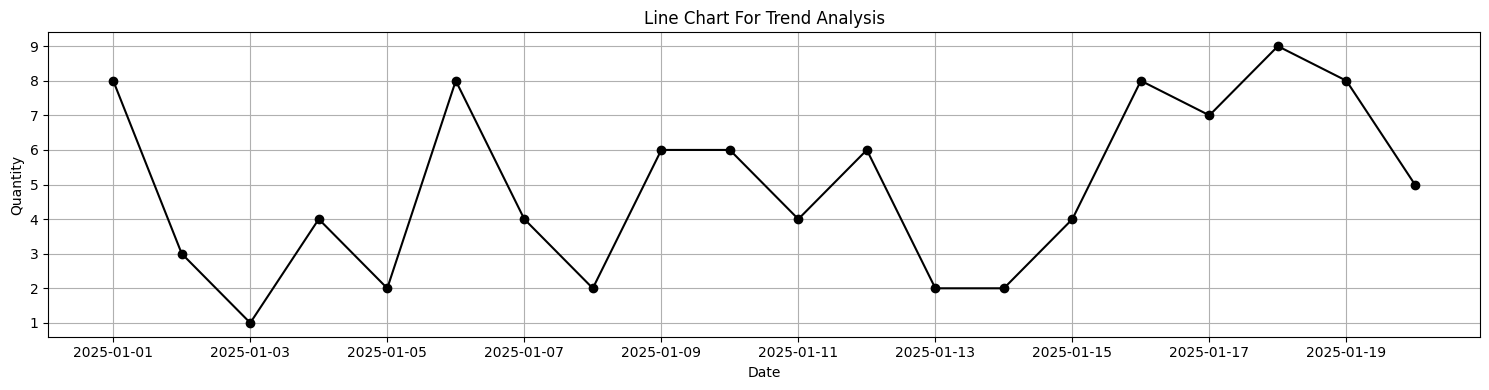

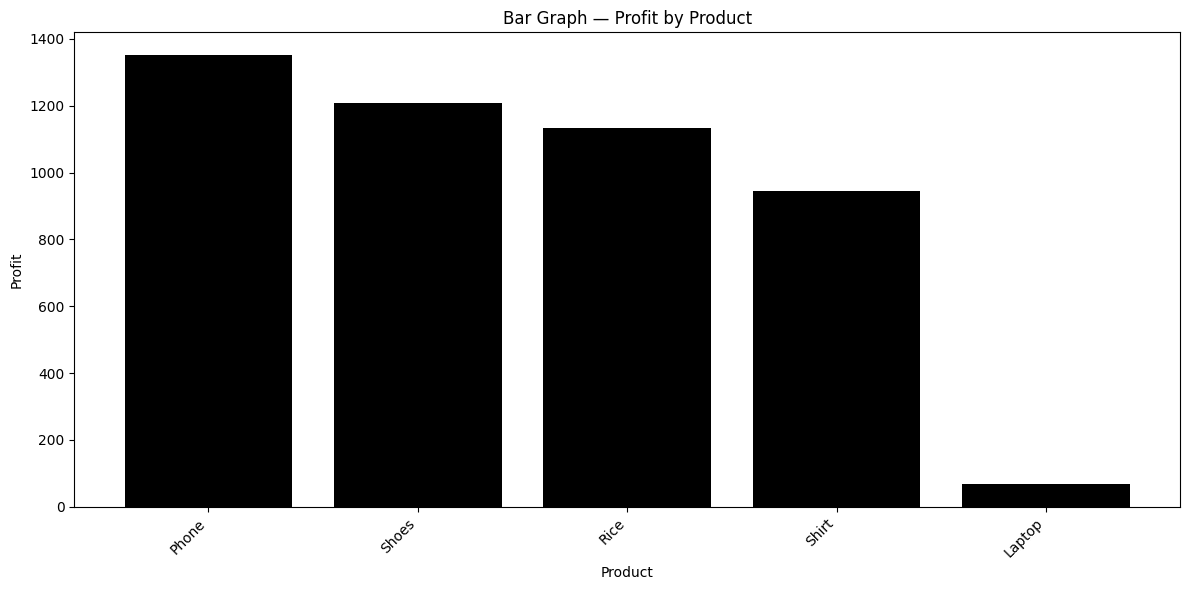

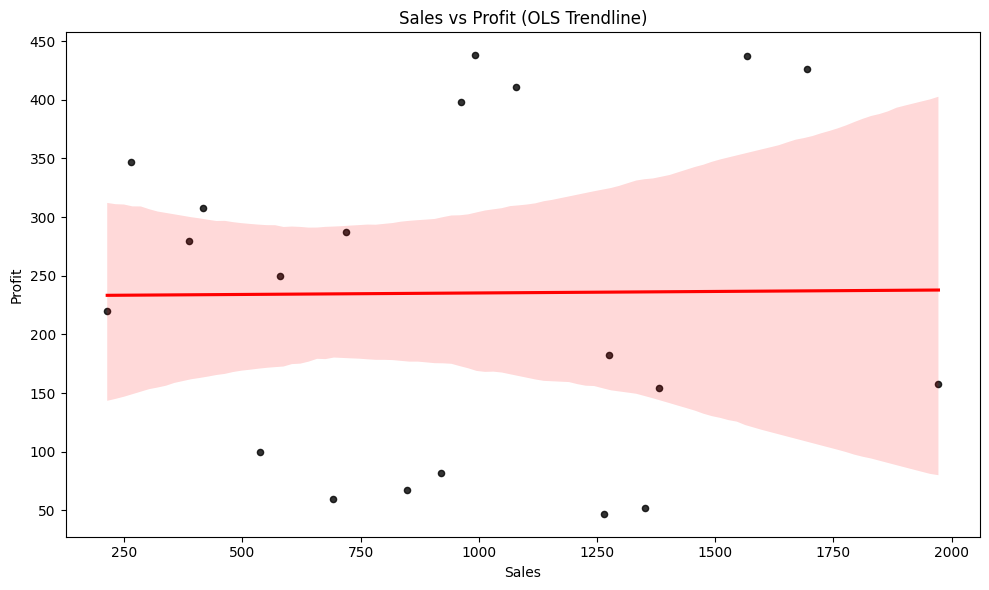

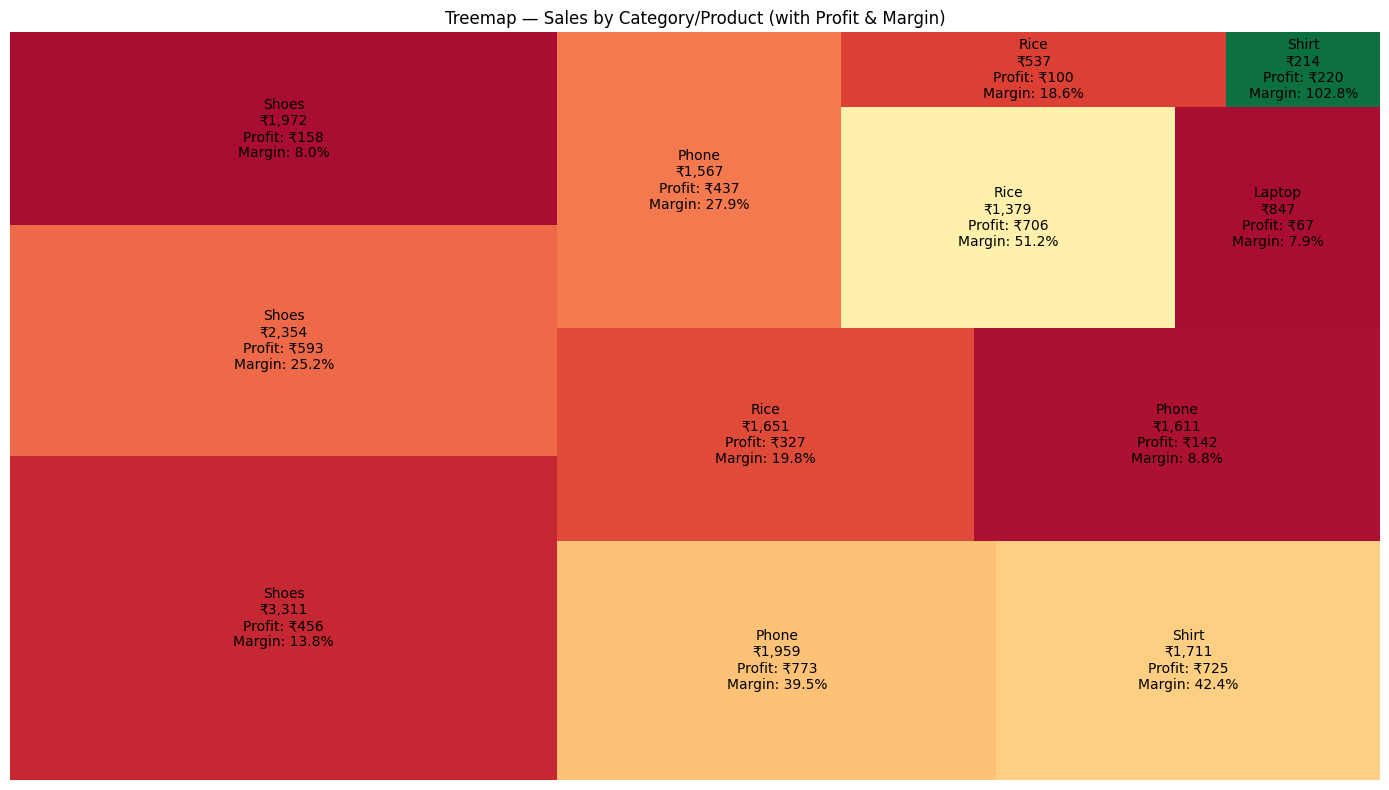

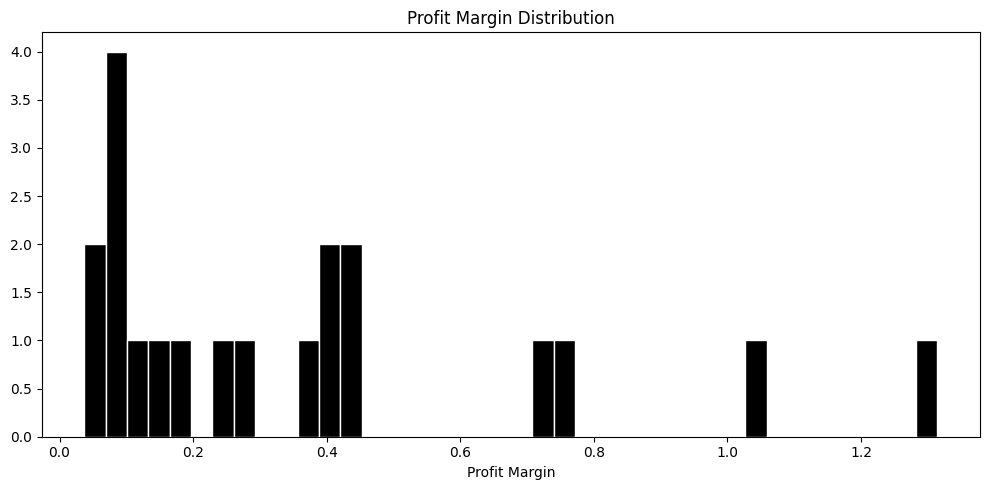

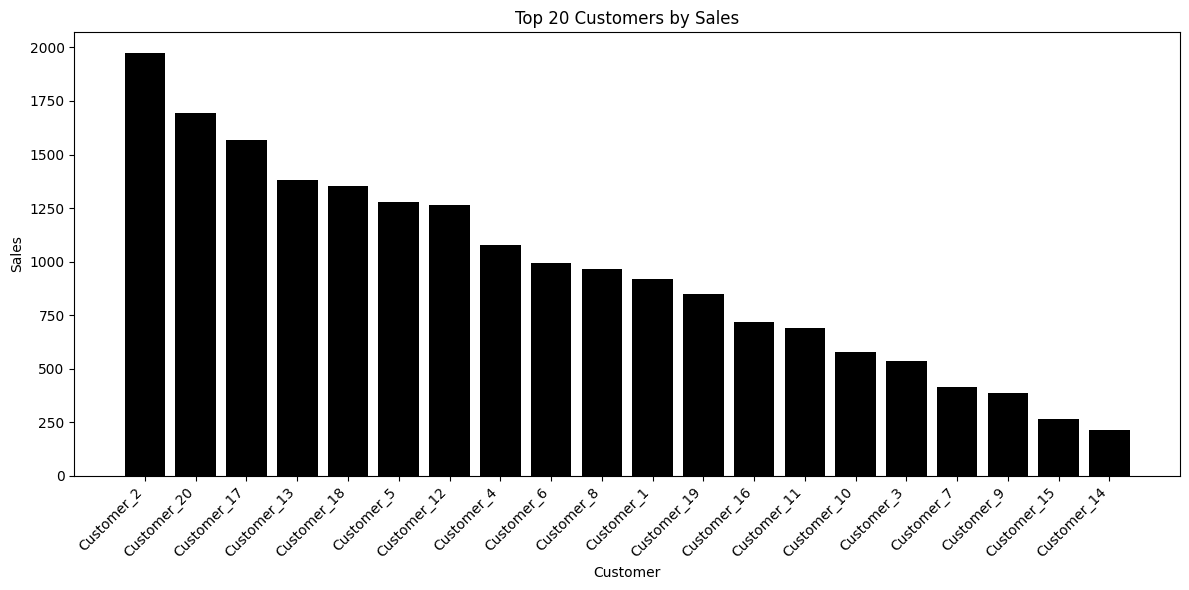

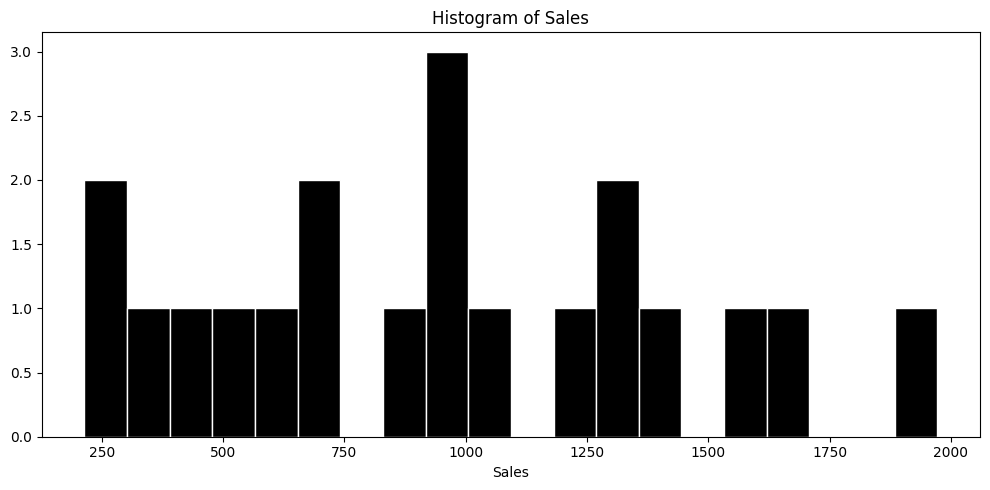

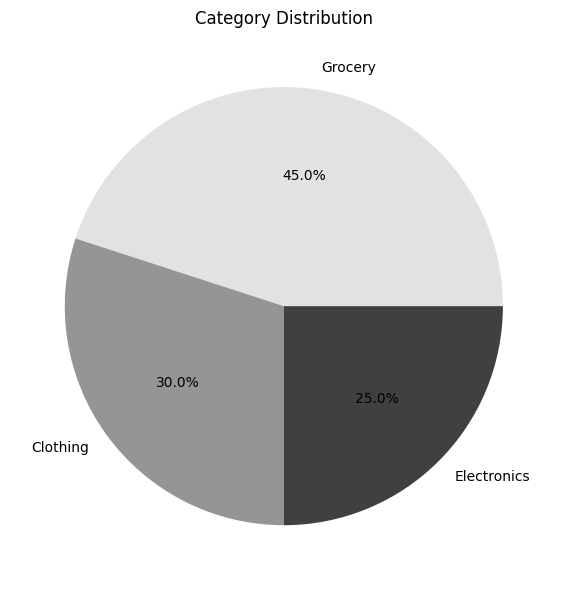

In [4]:
#Importing Library:

!pip install squarify

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import squarify   # pip install squarify
from statsmodels.formula.api import ols  # for a quick trendline if needed

# Load data
data = pd.read_excel("/content/sales_dataset.xlsx")
data.columns = [c.strip() for c in data.columns]


# 1) Quantity over time (Line)

plt.figure(figsize=(15,4))
plt.plot(data["Date"], data["Quantity"], marker='o', color="Black")
plt.title("Line Chart For Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2) Profit by Product (Bar)

plt.figure(figsize=(12,6))
prod_profit = data.groupby("Product", dropna=False)["Profit"].sum().sort_values(ascending=False)
plt.bar(prod_profit.index, prod_profit.values, color="Black")
plt.title("Bar Graph — Profit by Product")
plt.xlabel("Product")
plt.ylabel("Profit")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 3) Sales vs Profit (Scatter with OLS trendline using seaborn)
#    (keeps the simple look but adds a trendline similar to px.scatter trendline)

plt.figure(figsize=(10,6))
sns.regplot(x="Sales", y="Profit", data=data, scatter_kws={"s":20, "color":"black"}, line_kws={"color":"red"})
plt.title("Sales vs Profit (OLS Trendline)")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


# 4) Enhanced Treemap (Category -> Product) with Sales, Profit and Margin
#    Uses squarify to draw rectangles and matplotlib text to mimic the 'super treemap'

# aggregate to Category/Product level
if "Category" in data.columns and "Sales" in data.columns:
    if "Product" in data.columns and "Profit" in data.columns:
        df_agg = data.groupby(["Category", "Product"], dropna=False).agg(
            Sales=("Sales", "sum"),
            Profit=("Profit", "sum")
        ).reset_index()
    elif "Product" in data.columns:
        df_agg = data.groupby(["Category", "Product"], dropna=False).agg(
            Sales=("Sales", "sum")
        ).reset_index()
        df_agg["Profit"] = 0.0
    else:
        df_agg = data.groupby(["Category"], dropna=False).agg(
            Sales=("Sales", "sum"),
            Profit=("Profit", "sum") if "Profit" in data.columns else ("Sales", "sum")
        ).reset_index()
        if "Profit" not in df_agg.columns:
            df_agg["Profit"] = 0.0

    # compute margin, sort for nicer layout
    df_agg["Profit_Margin"] = np.where(df_agg["Sales"] != 0, df_agg["Profit"] / df_agg["Sales"], 0.0)
    df_agg = df_agg.sort_values("Sales", ascending=False).reset_index(drop=True)

    # Prepare sizes (using Sales)
    sizes = df_agg["Sales"].values
    labels = []
    for i, row in df_agg.iterrows():
        prod_label = str(row.get("Product", row.get("Category")))
        sales_val = f"₹{row['Sales']:,}"
        profit_val = f"₹{row['Profit']:,}"
        margin_val = f"{row['Profit_Margin']:.1%}"
        # multi-line label
        lbl = f"{prod_label}\n{sales_val}\nProfit: {profit_val}\nMargin: {margin_val}"
        labels.append(lbl)

    # Choose color mapping based on margin (green->red map)
    # normalize margins to 0-1 for cmap
    margins = df_agg["Profit_Margin"].values
    # clamp and normalize for colormap
    norm = plt.Normalize(vmin=np.min(margins), vmax=np.max(margins))
    cmap = plt.cm.RdYlGn

    colors = [cmap(norm(m)) for m in margins]

    plt.figure(figsize=(14,8))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.95, text_kwargs={'fontsize':10})
    plt.title("Treemap — Sales by Category/Product (with Profit & Margin)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# 5) Profit Margin Distribution (Histogram)

if "Profit" in data.columns and "Sales" in data.columns:
    data = data.assign(Profit_Margin = np.where(data["Sales"] == 0, 0.0, data["Profit"] / data["Sales"]))
    plt.figure(figsize=(10,5))
    plt.hist(data["Profit_Margin"].dropna(), bins=40, color="Black", edgecolor="white")
    plt.title("Profit Margin Distribution")
    plt.xlabel("Profit Margin")
    plt.tight_layout()
    plt.show()


# 6) Top Customers by Sales (Top 20)

if "Customer" in data.columns and "Sales" in data.columns:
    cust = data.groupby("Customer", dropna=False)["Sales"].sum().sort_values(ascending=False).head(20)
    plt.figure(figsize=(12,6))
    plt.bar(cust.index.astype(str), cust.values, color="Black")
    plt.title("Top 20 Customers by Sales")
    plt.xlabel("Customer")
    plt.ylabel("Sales")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 7) Sales Distribution (Histogram)

plt.figure(figsize=(10,5))
plt.hist(data["Sales"].dropna(), bins=20, color="Black", edgecolor="white")
plt.title("Histogram of Sales")
plt.xlabel("Sales")
plt.tight_layout()
plt.show()


# 8) Category Pie Chart

if "Category" in data.columns:
    plt.figure(figsize=(6,6))
    P_Chart = data["Category"].value_counts()
    plt.pie(P_Chart, labels=P_Chart.index, autopct="%1.1f%%", colors=plt.cm.Greys(np.linspace(0.2, 0.8, len(P_Chart))))
    plt.title("Category Distribution")
    plt.tight_layout()
    plt.show()
